#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка библиотек

In [4]:
# импорт библиотек
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
import warnings

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import (
    mean_squared_error,
    make_scorer) 

from sklearn.model_selection import train_test_split, RandomizedSearchCV 

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

## Функции

In [6]:
# функция №1 для изучения датафрейма
def data_info(data):
    print(f"Размер датасета {data.shape}")
    print('_'*50)
    display(data.head(5))
    print('_'*50)
    data.info()
    print('_'*50)
    display(data.describe())

In [7]:
# функция №2 для удаления дубликатов
def duplicat(data):
    print(f"Размер DataFrame с дубликатами: {data.shape}")
    print(f'Количество строк дубликатов: {data.duplicated().sum()}')
    deduped_data = data.drop_duplicates()
    print(f"Размер DataFrame без дубликатов: {deduped_data.shape}")
    return deduped_data.head()

In [8]:
# функция №3 для поиска неявных дубликатов
def hidden_duplicat(data):
    for column in data.columns:
        if data[column].dtype == 'object':
            unique_values = data[column].unique()
            print(f"Уникальные значения для столбца '{column}': {unique_values}")

## Загрузка данных

In [10]:
# загрузка данных
pth1 = 'C:\\datasets\\taxi\\taxi.csv'
pth2 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [11]:
# отключеие предупреждений
warnings.filterwarnings('ignore')

## Предобработка данных

In [13]:
# Общая информация о датасете 
data_info(data)

Размер датасета (26496, 2)
__________________________________________________


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
__________________________________________________


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [14]:
# Поиск явных дубликатов 
duplicat(data)

Размер DataFrame с дубликатами: (26496, 2)
Количество строк дубликатов: 0
Размер DataFrame без дубликатов: (26496, 2)


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [15]:
# Поиск неявных дубликатов
hidden_duplicat(data)

Уникальные значения для столбца 'datetime': ['2018-03-01 00:00:00' '2018-03-01 00:10:00' '2018-03-01 00:20:00' ...
 '2018-08-31 23:30:00' '2018-08-31 23:40:00' '2018-08-31 23:50:00']


**Вывод:**
- В дата сете 26496 строк и 2 столбца.
- Данные с 01.03.18 по 31.08.18
- Интервал между измерениями 10 минут 
- Пропусков нет, дубликатов нет
- Тип данных у num_orders корректный
- Столбец datetime лучше перевести datetime64 и сделать индексом для удобства

## Подготовка

In [18]:
# Изменение тип данных datetime с object на datetime64
data['datetime'] = pd.to_datetime(data.datetime)

In [19]:
# Установка индекса таблицы равным столбцу Datetime
data.set_index('datetime', inplace=True)

Проверим целостность данных. Является ли индекс даты монотонно возрастающим. Если порядок соблюдён, атрибут вернёт True, если нет — False

In [21]:
# Проверить, является ли индекс монотонно возрастающим
data.index.is_monotonic_increasing

True

Измением интервал ряда. Ресемплинг по часу. Значения просуммированы, это проще интерпретируется, чем использование других агрегационных функций.

In [23]:
# Ресемплирование по одному часу
data = data.resample('1H').sum()

## Исследовательский анализ данных

### Ресемплирование по одному часу и скользящее среднее

- Для изучения данных необходимо изучить все распределение - от марта до августа 2018.
- Для более детального исследования необходимо рассмотреть распределение в течение месяца. Лучше взять наиболее новые данные, то есть за август
- Также необходимо изучить распределение в течение недели
- Также необходимо изучить распределение в течение дня 

In [27]:
# Срез. Данные за август
df_aug =  data.loc['2018-08-01':]
# Срез. Данные за первую неделю августа 
df_aug_week = data.loc['2018-08-01':'2018-08-07']
# Срез. Данные за первый день августа
df_aug_day = data.loc['2018-08-01']

Чтобы во временном ряду снизить колебания, применим скользящее среднее. 
- Скользящее среднее  — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.
- Скользящее стандартное отклонение — стандартное отклонение по скользящему окну

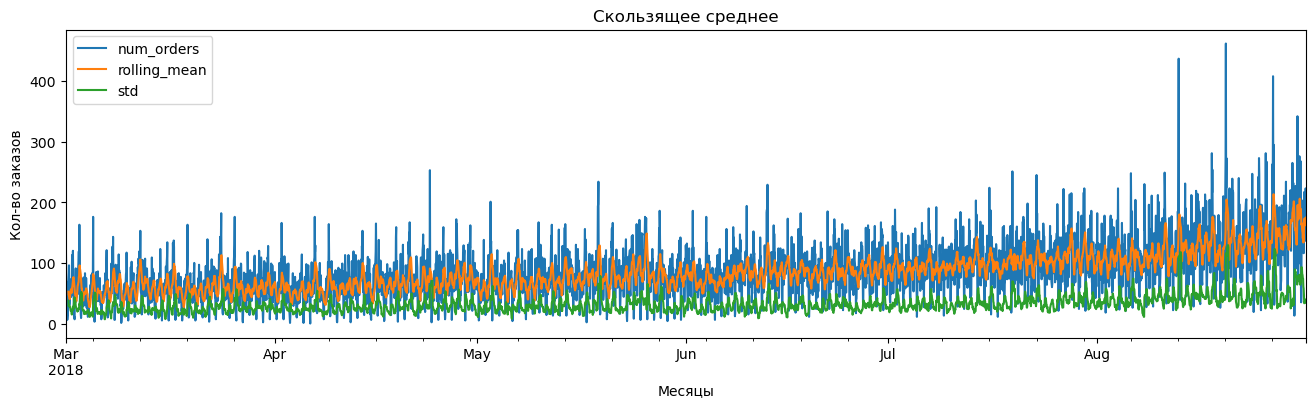

In [29]:
# Скользящее среднее + станд. откл
# по всем данным 
figsize=(16,4)
data['rolling_mean'] = data['num_orders'].rolling(10).mean()
data['std'] = data['num_orders'].rolling(10).std()
data.plot(figsize=(16,4))
plt.title('Скользящее среднее')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

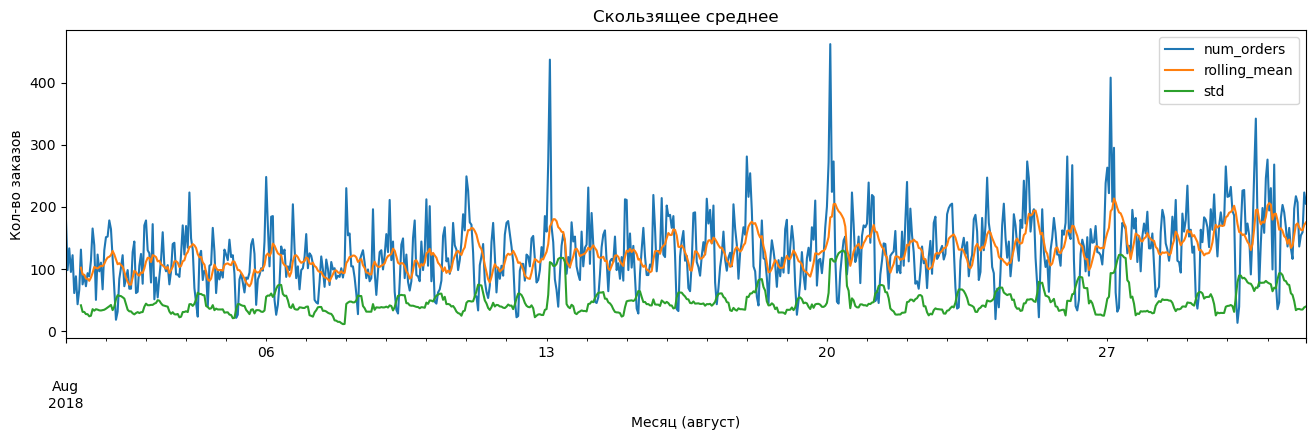

In [30]:
# Скользящее среднее + станд. откл
# в течение августа
df_aug['rolling_mean'] = df_aug.rolling(10).mean()
df_aug['std'] = df_aug['num_orders'].rolling(10).std()
df_aug.plot(figsize=figsize)
plt.title('Скользящее среднее')
plt.xlabel('Месяц (август)')
plt.ylabel('Кол-во заказов')
plt.show()

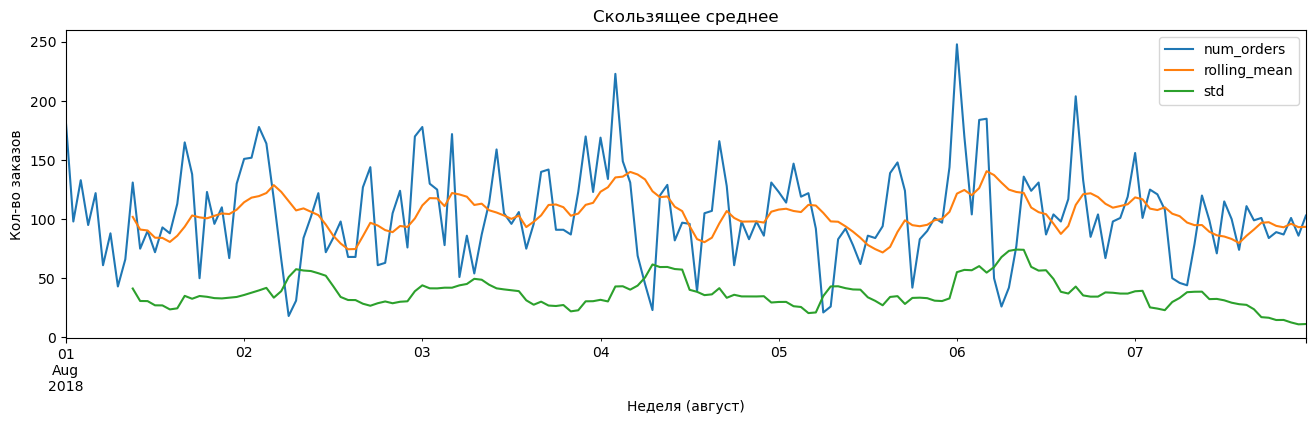

In [31]:
# Скользящее среднее + станд. откл
# в течение  первой недели августа 
df_aug_week['rolling_mean'] = df_aug_week.rolling(10).mean()
df_aug_week['std'] = df_aug_week['num_orders'].rolling(10).std()
df_aug_week.plot(figsize=figsize)
plt.title('Скользящее среднее')
plt.xlabel('Неделя (август)')
plt.ylabel('Кол-во заказов')
plt.show()

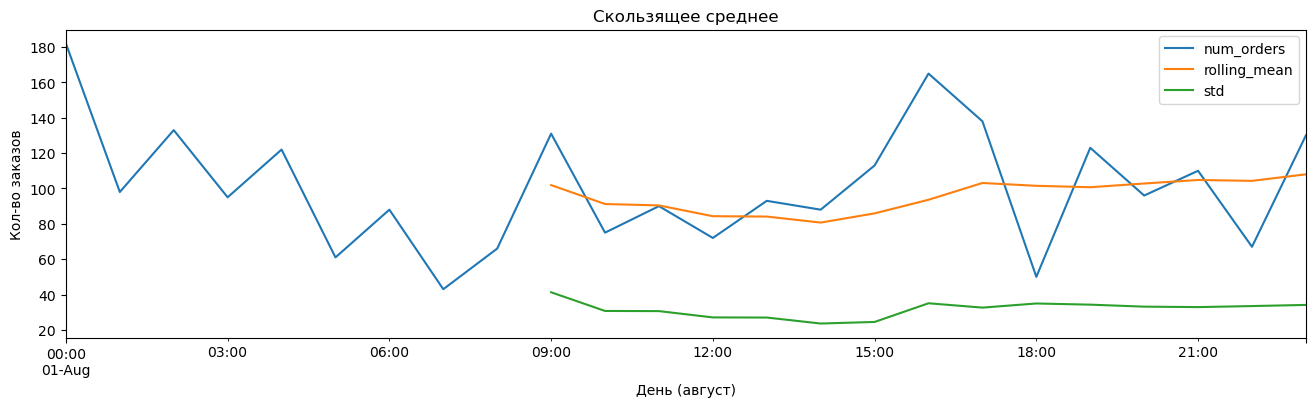

In [32]:
# Скользящее среднее + станд. откл
# в течение одного дня августа
df_aug_day['rolling_mean'] = df_aug_day.rolling(10).mean()
df_aug_day['std'] = df_aug_day['num_orders'].rolling(10).std()
df_aug_day.plot(figsize=figsize)
plt.title('Скользящее среднее')
plt.xlabel('День (август)')
plt.ylabel('Кол-во заказов')
plt.show()

**Вывод.**
На графике ресемплированных по 1 часу данных видно: 
-  Кол-во заказов изменяется в течение полугода. С марта по август увеличивается кол-во заказов
- Кол-во заказов изменяется в течение месяца. В некоторые дни, ткакие как 13, 20 и 27 - высокий спрос. К концу месяца спрос увеличивается. Возможно какие-то акции появились
- Кол-во заказов изменяется в течение недели. 1 августа- это ср, 2-чт, 3-пт, 4-сб, 5-вс, 6-пн, 7-вт. Заметно, что по утрам спрос ниже. К вечерму спрос увеличивается. В пятницу (3) выше спрос, по сравнению с другими днями (нет спада)
- Кол-во заказов изменяется в течение дня. Меньше всего с 5-8 часов утра. Затем увеличение заказов до 12 часов. Больше всего заказов в период 16-18 часов вечера. Связано с ритмом жизни города. Работа - дом 

**Вывод.**
На графике скользящего среднего и стандарного отклонения видно: 
- Скользящее среднее значение имеет такую же тенденцию, как и врменной ряд, но более сглаженный. Экстримальных значений нет. Аналогично и со скользящим стандартным отклонением

### Декомпозиция. Тренды и сезонность

In [36]:
# Декомпозиция
decomposed = seasonal_decompose(data['num_orders']) 
decomposed_aug = seasonal_decompose(df_aug['num_orders'])
decomposed_aug_week = seasonal_decompose(df_aug_week['num_orders'])

#### Тренд

Тренд — плавное изменение среднего значения ряда без повторяющихся закономерностей. Например, ежегодное увеличение объёма продаж авиабилетов.

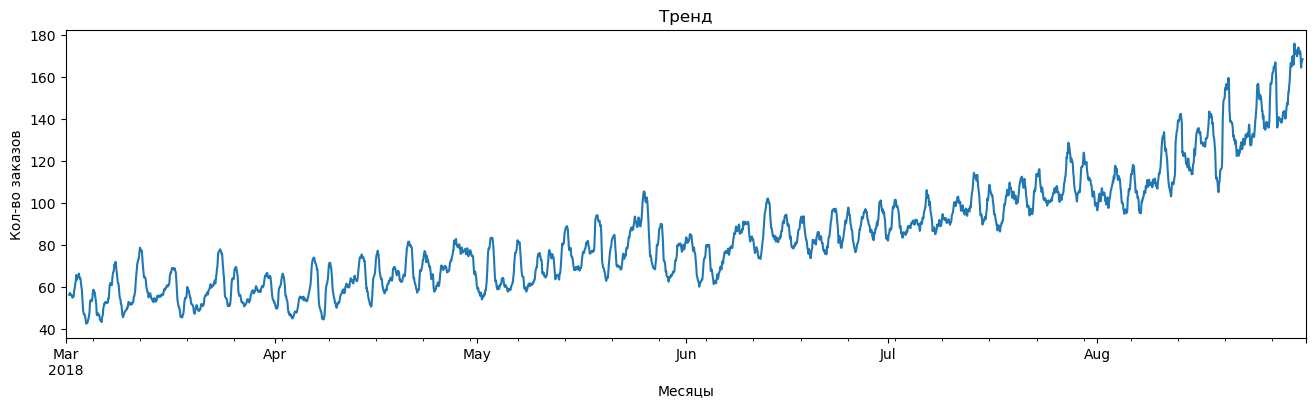

In [39]:
# Тренд за весь период
decomposed.trend.plot(figsize=figsize)
plt.title('Тренд')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

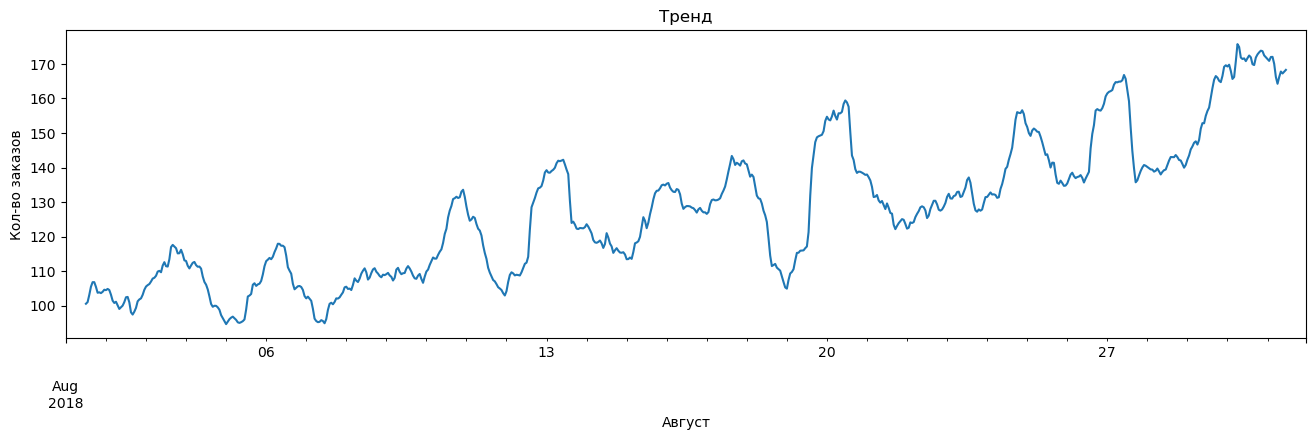

In [40]:
# Тренд за август
decomposed_aug.trend.plot(figsize=figsize)
plt.title('Тренд')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.show()

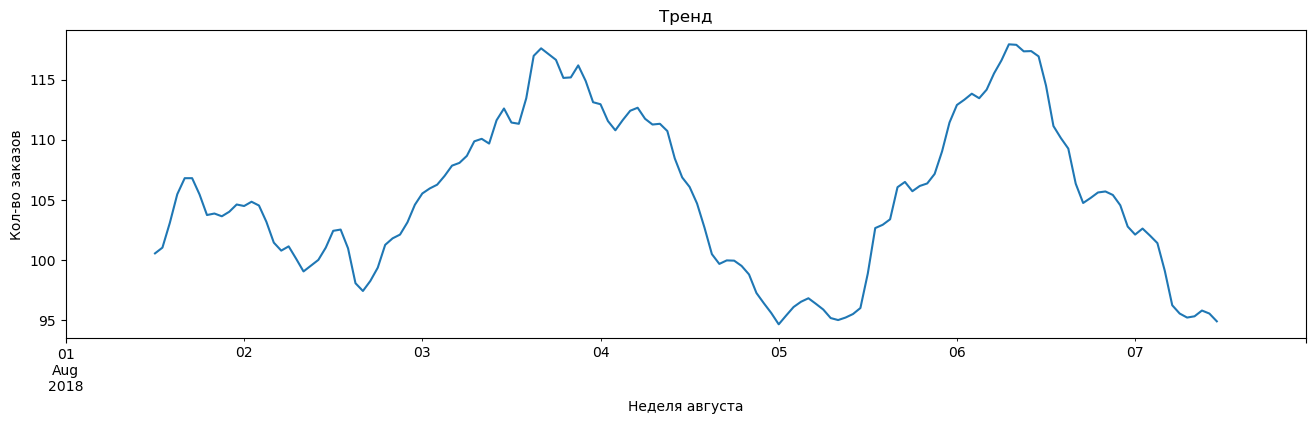

In [41]:
# Тренд за первую неделю августа
decomposed_aug_week.trend.plot(figsize=figsize)
plt.title('Тренд')
plt.xlabel('Неделя августа')
plt.ylabel('Кол-во заказов')
plt.show()

**Вывод.**
- Тред по общему периоду - рост спроса на заказ, причем относительно марта почти в 3 раза
- В течение недели тренд следующий: больше всего заказов пт, сб и пн. Меньше всего в вс
- Примечание: 1 августа- это ср, 2-чт, 3-пт, 4-сб, 5-вс, 6-пн, 7-вт

#### Сезонность

Сезонность — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж авиабилетов летом.

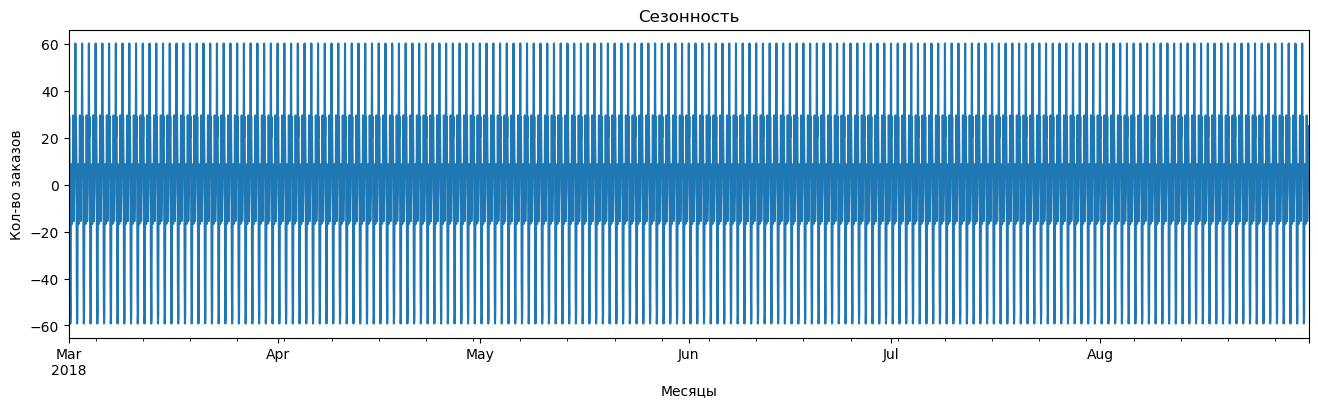

In [45]:
# Сезонность за весь период
decomposed.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

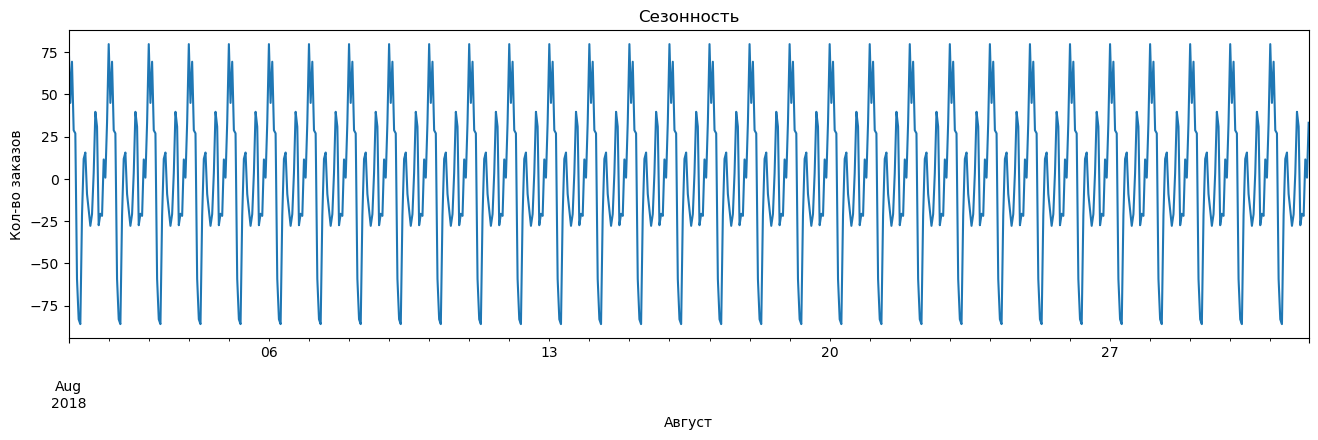

In [46]:
# Сезонность за август
decomposed_aug.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.show()

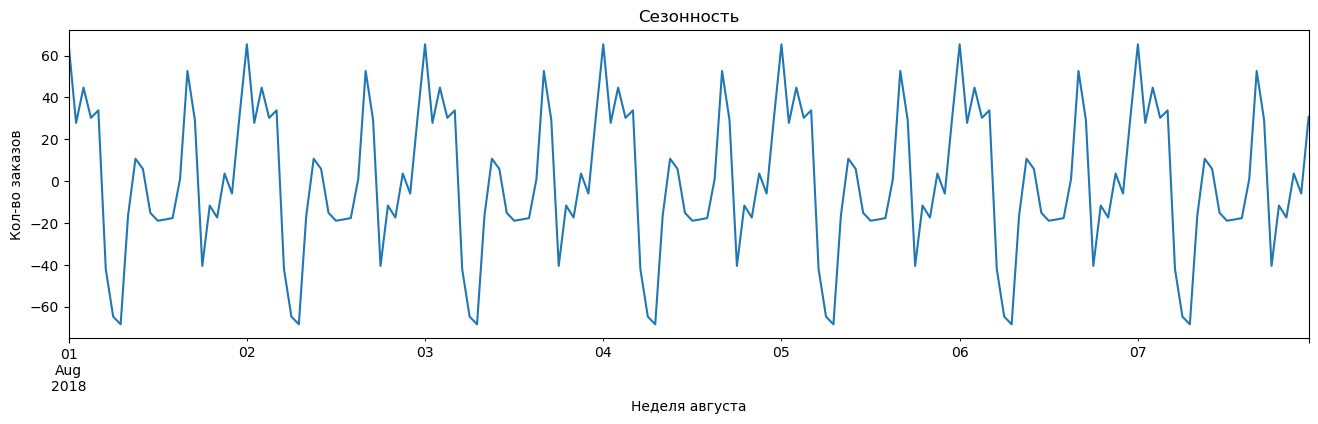

In [47]:
# Сезонность за первую неделю августа
decomposed_aug_week.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Неделя августа')
plt.ylabel('Кол-во заказов')
plt.show()

In [48]:
# Ресемплирование по одному дню
data_day_res = data.resample('1D').sum()
data_day_res =  data_day_res.loc['2018-08-01':]
decomposed_data_day_res = seasonal_decompose(data_day_res['num_orders']) 

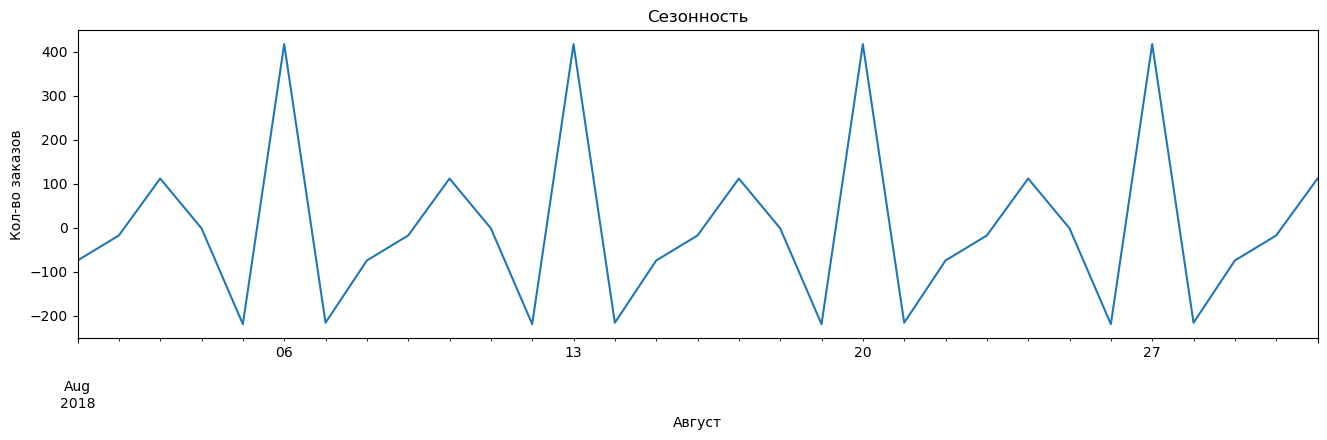

In [49]:
# Сезонность за август по одному дню
decomposed_data_day_res.seasonal.plot(figsize=figsize)
plt.title('Сезонность')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.show()

**Вывод.**
- Прослеживается часовая сезонность в сутках у временного ряда
- Прослеживается дневная сезонность в течение месяца у временного ряда

#### Остаток декомпозиции

Остаток декомпозиции - части ряда, которые не объясняются трендом и сезонностью.

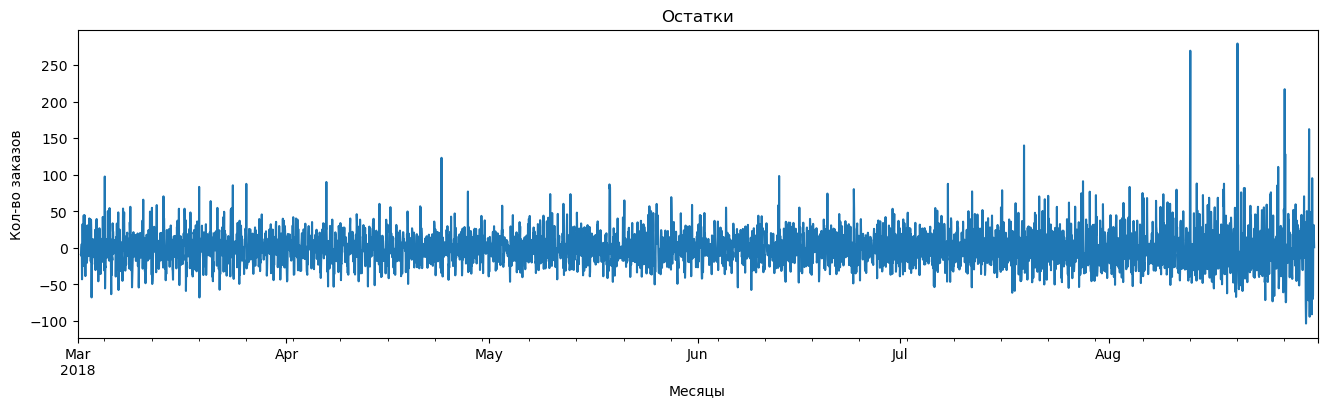

In [53]:
# Остатки за весь период
decomposed.resid.plot(figsize=figsize)
plt.title('Остатки')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

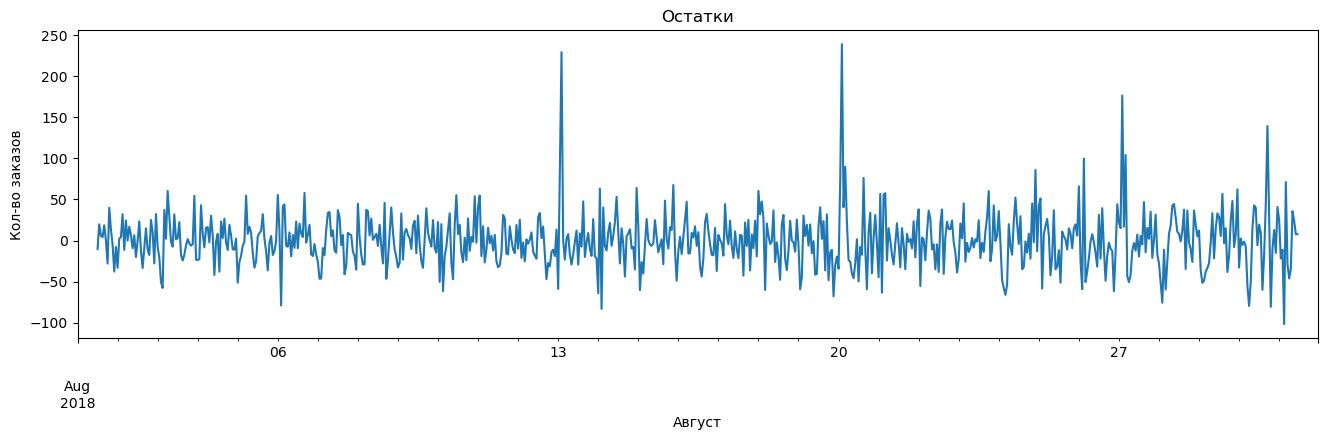

In [54]:
# Остатки за август
decomposed_aug.resid.plot(figsize=figsize)
plt.title('Остатки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.show()

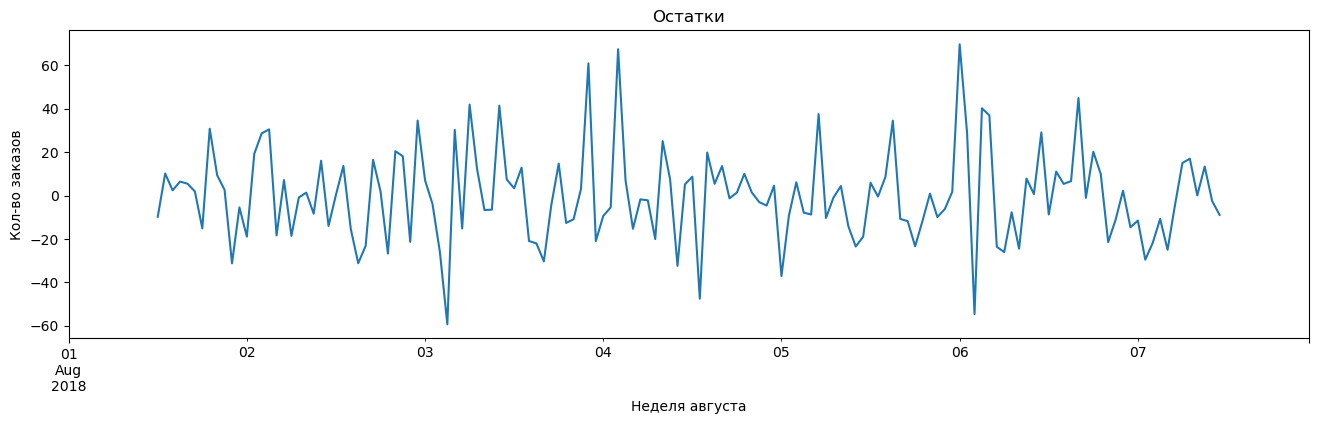

In [55]:
# Остатки за неделю августа
decomposed_aug_week.resid.plot(figsize=figsize)
plt.title('Остатки')
plt.xlabel('Неделя августа')
plt.ylabel('Кол-во заказов')
plt.show()

**Вывод.**
- Вины пики в течение месяца на сезонность в месяце
- Видны недельные пики, что может указывать на сезонность в неделе

## Изучение временного ряда

Тесты формальной проверки:
- тест Харки-Бера, 
- Тест Дики-Фуллера (ADF),
- Автокорреляционная функция (АКФ).

 ### Тест Дики-Фуллера

Это статистический тест, специально созданный для проверки того, являются ли одномерные данные временных рядов стационарными или нет. Этот тест основан на гипотезе и может сообщить нам степень вероятности, с которой она может быть принята. Это часто классифицируется в соответствии с одним из тестов unit root, он определяет, насколько сильно одномерные данные временных рядов следуют тренду. Давайте определим нулевую и альтернативные гипотезы,

- Ho (нулевая гипотеза): данные временных рядов нестационарны
- H1 (альтернативная гипотеза): данные временных рядов являются стационарными

Предположим, что альфа = 0.05, что означает (95% достоверности). Результаты теста интерпретируются с p-значением, если p> 0.05 не отклоняет нулевую гипотезу, иначе, если p <= 0.05 отклоняет нулевую гипотезу.

In [61]:
# Отобразите результаты теста
result = adfuller(data['num_orders'])
print('Augmented Dickey-Fuller Test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Интерпретация результатов теста
if result[1] <= 0.05:
    print('Отвергаем нулевую гипотезу - ряд стационарный')
else:
    print('Не можем отвергнуть нулевую гипотезу - ряд нестационарный')

Augmented Dickey-Fuller Test:
ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Отвергаем нулевую гипотезу - ряд стационарный


- Тестовая статистика adf (-3.068924) больше критического значения на 1% уровне (-3.431842), то нулевая гипотеза принимается, т.е. присутствует единичный корень и ряд нестационарен.
- Однако Тестовая статистика adf меньше критического значения на 5% уровне (-2.862199),а p-значение (0.028940) меньше 0.05, нулевая гипотеза о наличии единичного корня отвергается.

    1) 5% уровень значимости является наиболее распространенным и общепринятым в статистической практике. Он предоставляет разумный компромисс между вероятностью ошибок первого и второго рода. То есть при 5% уровне значимости сохраняется небольшая, но приемлемая вероятность отвергнуть верную нулевую гипотезу.

    2) 1% уровень значимости используется, когда требуется более строгий критерий для отвержения нулевой гипотезы. Он уменьшает вероятность ошибки первого рода (ложное отвержение нулевой гипотезы), но увеличивает вероятность ошибки второго рода (неверное принятие нулевой гипотезы).

**Вывод**
- Таким образом, с точки зрения надежности выводов, лучше придерживаться 5% уровня значимости, если нет серьезных оснований использовать более строгий 1% уровень. Выбор 5% считается хорошей отправной точкой и обеспечивает достаточную защиту от ошибочных выводов в большинстве случаев. Ряд стационарен

 ### Тест Харки-Бера 

Тест Харки-Бера является статистическим тестом, используемым для проверки нормальности распределения данных. Он основан на коэффициентах асимметрии (skewness) и эксцесса (kurtosis) выборки. Коэффициент асимметрии измеряет отклонение распределения от симметричности, а коэффициент эксцесса характеризует "остроконечность" распределения по сравнению с нормальным распределением.
- Нулевая гипотеза (H0):
Данные извлечены из нормального распределения.
- Альтернативная гипотеза (H1):
Данные не извлечены из нормального распределения.

- Тест Харки-Бера проверяет, насколько коэффициенты асимметрии и эксцесса выборки отклоняются от значений, которые ожидались бы при нормальном распределении (асимметрия = 0, эксцесс = 3).

In [67]:
# Проводим тест Харки-Бера
stat, p_value = stats.jarque_bera(data['num_orders'])

# Выводим результаты теста
print('Статистика:', stat)
print('p-value:', p_value)

# Устанавливаем уровень значимости
alpha = 0.05

# Интерпретация результата
if p_value < alpha:
    print('Распределение не является нормальным (отвергаем нулевую гипотезу)')
else:
    print('Распределение может быть нормальным (не можем отвергнуть нулевую гипотезу)')

Статистика: 3644.4335517264863
p-value: 0.0
Распределение не является нормальным (отвергаем нулевую гипотезу)


Результаты теста Харки-Бера с высокой степенью статистической значимости (p-value = 0,0) указывают на то, что данные не соответствуют нормальному распределению. Мы отвергаем нулевую гипотезу о том, что данные имеют нормальное распределение, т.к. p-value (0,0) меньше уровня значимости (0,05). 

In [69]:
# Рассчитываем коэффициенты асимметрии и эксцесса
skewness = stats.skew(data.num_orders)
kurtosis = stats.kurtosis(data.num_orders)

# Выводим коэффициенты
print('Коэффициент асимметрии (skewness):', skewness)
print('Коэффициент эксцесса (kurtosis):', kurtosis)

# Ожидаемые значения для нормального распределения
print('Для нормального распределения:')
print('Ожидаемый коэффициент асимметрии:', 0)
print('Ожидаемый коэффициент эксцесса:', 3)

Коэффициент асимметрии (skewness): 1.1885516779344458
Коэффициент эксцесса (kurtosis): 3.7624571387574486
Для нормального распределения:
Ожидаемый коэффициент асимметрии: 0
Ожидаемый коэффициент эксцесса: 3


- Асимметрия: Положительное значение коэффициента асимметрии (1,18855) указывает на правую асимметрию в распределении данных. Это означает, что хвост распределения смещен вправо, а среднее и медиана сдвинуты в сторону меньших значений.
- Эксцесс: Коэффициент эксцесса (3,76246) выше ожидаемого для нормального распределения (3). Это указывает на более острый пик и более "тяжелые" хвосты в распределении данных по сравнению с нормальным распределением.

- В целом, результаты теста Харки-Бера показывают, что распределение данных отличается от нормального распределения. Данные демонстрируют правую асимметрию и более тяжелые хвосты, что может указывать на наличие крайних значений или аномальных данных.

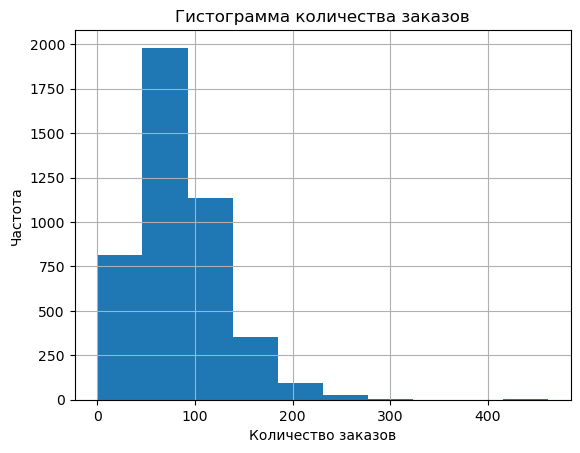

In [71]:
# гистограмма 
data['num_orders'].hist()
plt.title('Гистограмма количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()

**Вывод**
- Данные асимметричны
- Данные распределены ненормально.
Также в качестве теста на нормальность распределеня данных можно использовать тест Шапиро-Уилка. 

 ### Автокорреляционная функция (АКФ)

Она показывает, как значения ряда коррелируют с собой в различные моменты времени. Автокорреляционная функция (АКФ) позволяет изучить зависимость между значениями временного ряда в различные моменты времени. Она определяется как коэффициент корреляции между текущим значением ряда и его значением, сдвинутым на определенный лаг

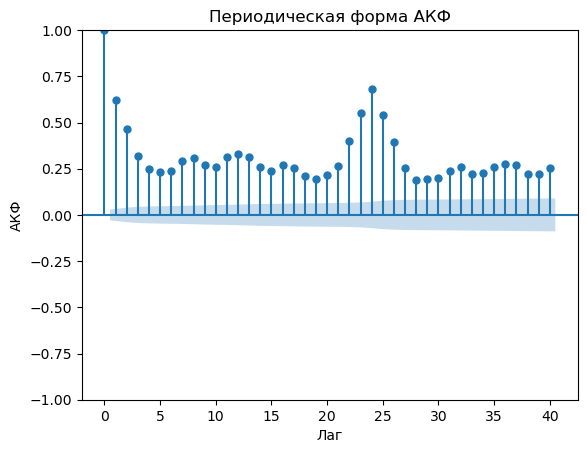

In [75]:
# Построение графика АКФ
plot_acf(data['num_orders'], lags=40)
plt.xlabel('Лаг')
plt.ylabel('АКФ') 
plt.title('Периодическая форма АКФ')
plt.show()

- Периодическая форма. 
Периодически повторяющиеся значения АКФ, с пиками через определенные интервалы, указывают на наличие сезонной составляющей в ряде.
- Наблюдается  сезонность в сутках, каждые 24 часа
- Если автокорреляционная функция значительно отличается от нуля только на нескольких первых лагах и быстро снижается, это может указывать на стационарность временного ряда. Если же корреляции сохраняются на более длинных лагах, это может говорить о нестационарности. Однако, если представленный период слишком мал по сравнению с полным рядом, то по этому графику нельзя делать однозначные выводы о характере стационарност

### Вывод  

- Тест Харки-Бера: Распределение не является нормальным
- АКФ: Периодическая форма АКФ
- Тест Дики-Фуллера: единичных корней нет, ряд стационарен.
Таким образом, ряд является стационарным с вероятностью ошибки 5%

## Подготовка к обучению

Создадим признаки для горизонта прогнозирования в один шаг.
Напишем функцию `make_features` для создания признаков. Разберём каждый тип признаков:
1. Календарные признаки (англ. calendar features)
2. «Отстающие значения» (англ. lag features)
3. Скользящее среднее

Календарыне признаки должны подчеркивать сезонность. При сезонности нужно создавать признаки, например, часа (час одного дня похож на час другого дня).
Таким образом подходящие признаки:
- Признак день недели: т.к. у нас есть недельная сезонность.
- Признак час: т.к. есть часовая (суточная) сезонность.
- Признак lag: это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.
- Признак rolling: это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда
Не подходящие параметры: 
- Признак год: У нас данных меньше года. Поэтому будет просто константа.
- Признак месяц: аналогично году, у нас в истории всего один март, май. Да и горизонт прогноза - часы. Поэтому сезонность времени года будет просто в тренде уже заложена.
- Признак день: также не подходит, у нас нет сезонности внутри месяца, будет просто последовательность чисел.

In [82]:
# Функция признаков:
def make_features(data, max_lag, rolling_mean_size):
    # Добавляет признаки "день недели" и "час"
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # Создает признаки с лагами
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # Вычисляет скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
     
    return data

Удалим столбцы rolling_mean и std, которые использовали для разведовочного анализа и используем функцию make_features, чтобы подобрать оптимальное число лагов

In [84]:
#удаление столбцов 
data = data.drop(['rolling_mean','std'], axis=1)

In [85]:
# посмотрим исходные данные
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Выбор max_lag = 25, так как это соответсвует почти суткам. Выбор rolling_mean_size = 10

In [87]:
#создание признаков 
data = make_features(data, 25, 10)

In [88]:
# удаление образовавшиеся пропусков
data = data.dropna()

In [89]:
#разделение на выборки без перемешивания 
train, test = train_test_split(data, shuffle=False, test_size=0.15, random_state=42)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
    
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# проверка размера 
print('Размер тренировочной выборки- {:.0%}'.format(features_train.shape[0]/data.shape[0]))
print('Размер тестовой выборки - {:.0%}'.format(features_test.shape[0]/data.shape[0]))

Размер тренировочной выборки- 85%
Размер тестовой выборки - 15%


## Обучение для оптимизации гиперпараметров и промежуточной оценки моделей 

In [91]:
# Определение кросс-валидации с разделением по времени
tscv = TimeSeriesSplit(n_splits=5)

In [92]:
#функция для подбора параметров 
def model_analysis(clf, parameters, features_train, target_train):
    random_search = RandomizedSearchCV(estimator=clf,
                                  param_distributions=parameters,
                                  cv=tscv,
                                  n_jobs=-1,
                                  scoring='neg_root_mean_squared_error',
                                  refit=True)
    model_fit = random_search.fit(features_train, target_train)
    best_score = model_fit.best_score_
    best_params = model_fit.best_params_
    best_model = model_fit.best_estimator_
    return best_model, best_score, best_params 

###  LinearRegression

In [94]:
# Определение пространства поиска гиперпараметров
lr_params = {
    "model__fit_intercept": [True, False],
    "model__copy_X": [True, False]
}

# Создание конвейера с LinearRegression
lr_clf = Pipeline(steps=[("model", LinearRegression())])

# Вызов функции анализа модели
lr_best_model, lr_best_score, lr_best_params = model_analysis(lr_clf, lr_params, features_train, target_train)

print(f"Лучший счет: {lr_best_score:.4f}")
print(f"Лучшие параметры: {lr_best_params}")

Лучший счет: -26.3791
Лучшие параметры: {'model__fit_intercept': False, 'model__copy_X': True}


###  DecisionTreeRegressor

In [96]:
# Определение пространства поиска гиперпараметров
dtr_params = {
    "model__max_depth": [2, 4, 6, 8, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

# Создание конвейера с деревом решений
dtr_clf = Pipeline(steps=[("model", DecisionTreeRegressor())])

# Вызов функции анализа модели
dtr_best_model, dtr_best_score, dtr_best_params = model_analysis(dtr_clf, dtr_params, features_train, target_train)

print(f"Лучший счет: {dtr_best_score:.4f}")
print(f"Лучшие параметры: {dtr_best_params}")

Лучший счет: -28.3063
Лучшие параметры: {'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 6}


###  KNeighborsRegressor

In [98]:
# Определение пространства поиска гиперпараметров
knn_params = {
    "model__n_neighbors": [3, 5, 7, 9, 11],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "minkowski"]
}

# Создание конвейера с KNeighborsRegressor
knn_clf = Pipeline(steps=[("model", KNeighborsRegressor())])

# Вызов функции анализа модели
knn_best_model, knn_best_score, knn_best_params = model_analysis(knn_clf, knn_params, features_train, target_train)

print(f"Лучший счет: {knn_best_score:.4f}")
print(f"Лучшие параметры: {knn_best_params}")

Лучший счет: -24.8135
Лучшие параметры: {'model__weights': 'uniform', 'model__n_neighbors': 9, 'model__metric': 'manhattan'}


### CatBoostRegressor

In [ ]:
# Определение пространства поиска гиперпараметров
cat_params = {
    "model__learning_rate": [ 0.1, 0.2, 0.3],
    "model__depth": [2, 4, 6, 8, 10],
    "model__iterations": [50, 100, 150, 200]
}

# Создание конвейера с CatBoostRegressor
cat_clf = Pipeline(steps=[("model", CatBoostRegressor(random_state=42))])

# Вызов функции анализа модели
cat_best_model, cat_best_score, cat_best_params = model_analysis(cat_clf, cat_params, features_train, target_train)

print(f"Лучший счет: {cat_best_score:.4f}")
print(f"Лучшие параметры: {cat_best_params}")

## Выбор лучшей модели

In [ ]:
# сводная таблица 
table_model = pd.DataFrame({
    'LinearRegression': [lr_best_score, lr_best_params],
    'DecisionTreeRegressor': [dtr_best_score, dtr_best_params],
    'KNeighborsRegressor': [knn_best_score, knn_best_params],
    'CatBoostRegressor': [cat_best_score, cat_best_params]
}, index=['best_score', 'best_params'])
# просмотр таблицы
table_model

Метрики у моделей довольно близки. Лучшая метрика у модели CatBoostRegressor и составляет RMSE=23,6

## Проверка лучшей модели на адекватность

Модель DummyRegressor является очень простой и может быть использована только в качестве базовой линии. Она не учитывает какие-либо временные зависимости или тренды в данных.

In [ ]:
# обучение модели
model_dmr = DummyRegressor(strategy="mean")
model_dmr.fit(features_train, target_train)

#предсказание модели
predict_dmr = model_dmr.predict(features_test)

rmse_dmr = mean_squared_error(target_test, predict_dmr, squared=False)
print('RMSE модели dmr равна:', rmse_dmr)

DummyRegressor имеет метрику хуже, чем CatBoostRegressor

## Предсказание на тесте

In [ ]:
# предсказание на тесте
y_pred = cat_best_model.predict(features_test)
# получение метрики
rmse_pred = mean_squared_error(target_test, y_pred) ** 0.5
print('RMSE на тестовой выборке =', rmse_pred)

- На тестовой выборке модель CatBoostRegressor показала метрику RMSE 41.5, что соответствует требованиям заказчика (RMSE не более 48).
- Построим график за последние 5 дней, чтобы сравнить предсказанное значение с тестовым значением целевого признака

In [ ]:
# построим график для последних 120 позиций (5 дней, так как ресеплинг по часу)
plt.figure(figsize=(20,8))

plt.plot(target_test[-120:], label='Истина')
plt.plot(target_test[-120:].index,  y_pred[-120:], label='Пресказание')

plt.title('Сравнение пресказанных и истинных значений')
plt.legend();

## Заключение

- Была проведена подготова временного ряда.  
- Был проведен исследовательский анализ данных
- Были определены скользящее среднее и стандартное отклоенение
- Были проведены тесты на стационарность
- Была выполнена подготовка временного ряда к обучению
- Были подобраны гиперпараметры и модель по метрике RSME по кросс-валидации
- Выбарана лучшая модель CatBoostRegressor с гиперпараметрами.`model__learning_rate`= 0.1, `model__iterations`= 200, `model__depth`= 6
- Для временного ряда `max_lag`=25, `rolling_mean_size`=10
- Лучшая модель с лучшими параметрами была была проверена на тестовой выборке. Метрика составляет 41,5
- Результат тестирования на тестовой выборке CatBoostRegressor лучше, чем у константной модели DummyRegressor. Адекватность пройдена 